# Double/Debiased Machine Learning Part 1: The Frisch-Waugh-Lovell (FWL) theorem

The FWL theorem is a theorem that acts as a workforce for the Double Machine Learning literature in Causal Inference.

As part of learning Viktor Chernozhukov et al.'s influential paper on Double Machine Learning ([Chernozhukov et al., 2016](https://arxiv.org/pdf/1608.00060)), it became apparent that becoming intimately familiar with this theorem a necessary condition for understanding DML.

Therefore, we try to do a deep-dive here. The following is mostly an adaptation from Chernozhukov's book on Causal Inference (https://causalml-book.org/), but adding a bit of content from my end to try and make myself understand it better. We also focus on *linear* regression. Therefore, a lot of the code below isn't really mine, although I do add on to it quite a bit.

**Rough Table of Contents**:
1. Create function for classical OLS and simulate results ($R^2, \hat\beta_1$)
2. Create function for LASSO and simulate results ($R^2, \hat\beta_1$)
3. Investigate distributions of $\beta_1$ under OLS and LASSO.
4. Create function for Partialled-out LASSO (via FWL) and simulate results ($R^2, \hat\beta_1$)
5. Investigate distributions of $\beta_1$ under OLS, LASSO, and FWL

# Data Simulator

In [1]:
import numpy as np
import pandas as pd

def generate_data_simple(n, beta_1=2):

  # define true parameters
  mu, sigma = 0, 1 # mean and standard deviation
  beta_2 = 1

  # simulate data
  X = np.random.normal(mu, sigma, size=n)
  W = np.random.normal(mu, sigma, size=n)
  D = np.random.binomial(1,0.5,size=n)
  e = np.random.normal(0,1,size=n)
  Y = beta_1 * D + beta_2 * W + e

  # convert to pandas dataframe
  data = pd.DataFrame({
      'Y': Y,
      'D': D,
      'W': W,
      'X': X,
      'e': e
    })

  return data

# OLS

In [2]:
# libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = generate_data_simple(50)

In [49]:
def run_ols(df, model_base, treat='D'):
  """
  example: model_base = 'Y ~ D + W'
  """
  # fit model
  base = smf.ols(model_base, data=df)
  results_base = base.fit()

  # output
  n,p = base.exog.shape
  rsquared = results_base.rsquared
  rsquared_adj = results_base.rsquared_adj
  beta_1 = results_base.params[treat]

  return pd.DataFrame({'p':[p],'used_p':[p],'R^2': [rsquared], 'Adj R^2': [rsquared_adj], 'beta_1': [beta_1]})

In [4]:
model_base = 'Y ~ D + W'
run_ols(df, model_base)

,p,used_p,R^2,Adj R^2,beta_1
0,3,3,0.575434,0.557368,1.805514


In [5]:
model_base = 'Y ~ D+W+X+I(W**2)+I(W**3)+I(W**4)+I(X**2)+I(X**3)+I(X**4)'
run_ols(df, model_base)

,p,used_p,R^2,Adj R^2,beta_1
0,10,10,0.643028,0.56271,1.967452


# LASSO

The construction of the LASSO estimator operates a bit differently than OLS as the tuning parameter $\lambda$ needs to be tuned via cross-validation.

In [6]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import sklearn.linear_model as lm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


model_base = 'Y ~ D+W+X+I(W**2)+I(W**3)+I(W**4)+I(X**2)+I(X**3)+I(X**4)'

# fit OLS
base = smf.ols(model_base, data=df)
results_base = base.fit()

# extract matrices for lasso
X = base.data.exog[:,1:]
y = base.data.endog

# set up a pipeline that standardizes the parameters and employs cross-validation for LASSO tuning
lasso = Pipeline([('scale',StandardScaler()),
                  ('lasso',lm.LassoCV())])

# fit LASSO
lasso.fit(X,y)

Pipeline(steps=[('scale', StandardScaler()), ('lasso', LassoCV())])

In [7]:
# OLS coefficients
ols_coef = results_base.params.values[1:]
ols_names = results_base.params.index[1:]

# LASSO coefficients
lasso_coef = lasso.named_steps['lasso'].coef_
lasso_names = base.exog_names[1:]

# Create a DataFrame for comparison
df_comparison = pd.DataFrame({
    'Feature': ols_names,
    'OLS Coefficients': ols_coef,
    'Lasso Coefficients': lasso_coef
})

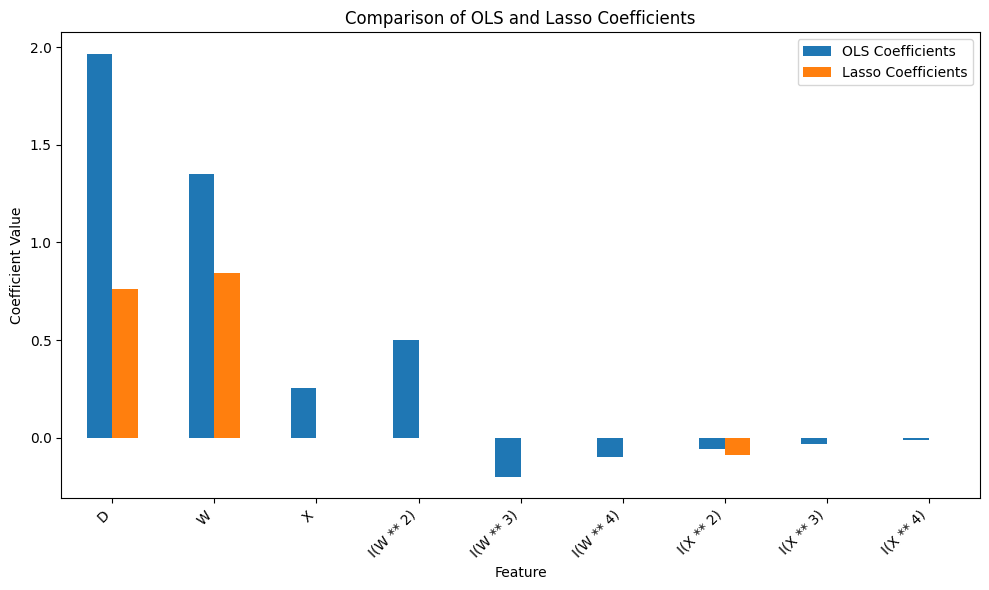

In [8]:
# Create a bar plot to compare OLS and Lasso coefficients
df_comparison.set_index('Feature').plot(kind='bar', figsize=(10,6))

# Add titles and labels
plt.title('Comparison of OLS and Lasso Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.tight_layout()  # Adjust layout for better display
plt.show()

To further elaborate, we can show how many coefficients each model uses:

In [9]:
# of coefficients in OLS:
print(f'Number of coefficients in OLS: {len(ols_coef)}')

# of coefficients in LASSO:
print(f'Number of coefficients in LASSO: {np.sum(lasso_coef != 0)}')

Number of coefficients in OLS: 9
Number of coefficients in LASSO: 3


Now, let's create the `run_lasso` function as we did similarly for OLS.

In [10]:
def run_lasso(df, model_base):
  """
  example: model_base = 'Y ~ D + W'
  """
  base = smf.ols(model_base, df)
  X = base.data.exog[:,1:]
  y = base.data.endog

  # set up LASSO pipeline
  lasso = Pipeline([('scale',StandardScaler()),
                     ('lasso',lm.LassoCV())])
  # fit lasso
  lasso.fit(X,y)

  # lasso coefs
  lasso_coef = lasso.named_steps['lasso'].coef_

  # output
  n,p = X.shape
  p += 1 # because we removed 1 before
  p_true = np.sum(lasso_coef != 0)
  mse = np.mean((y-lasso.predict(X))**2)
  rsquared = 1 - (mse/np.var(y))
  mse_adj = mse  * (n-1) / (n-p-1)
  rsquared_adj = 1 - (mse_adj/np.var(y))
  beta_1 = lasso_coef[0]
  return pd.DataFrame({'p':[p],'used_p':p_true,'R^2': [rsquared], 'Adj R^2': [rsquared_adj], 'beta_1': [beta_1]})

In [11]:
model_base = 'Y ~ D+W+X+I(W**2)+I(W**3)+I(W**4)+I(X**2)+I(X**3)+I(X**4)'
run_lasso(df, model_base)

,p,used_p,R^2,Adj R^2,beta_1
0,10,3,0.57506,0.466101,0.758801


In [12]:
model_base = 'Y ~ D+W+X+I(W**2)+I(W**3)+I(W**4)+I(X**2)+I(X**3)+I(X**4)'
run_ols(df, model_base)

,p,used_p,R^2,Adj R^2,beta_1
0,10,10,0.643028,0.56271,1.967452


In [13]:
model_base = 'Y ~ D+W'
run_ols(df, model_base)

,p,used_p,R^2,Adj R^2,beta_1
0,3,3,0.575434,0.557368,1.805514


We see here how with LASSO, $\hat\beta_1$ corrodes quite a bit. Below, we'll simulate the distributions of $\hat\beta_1$ via Monte Carlo simulation.

# Distribution of $\hat\beta_1$

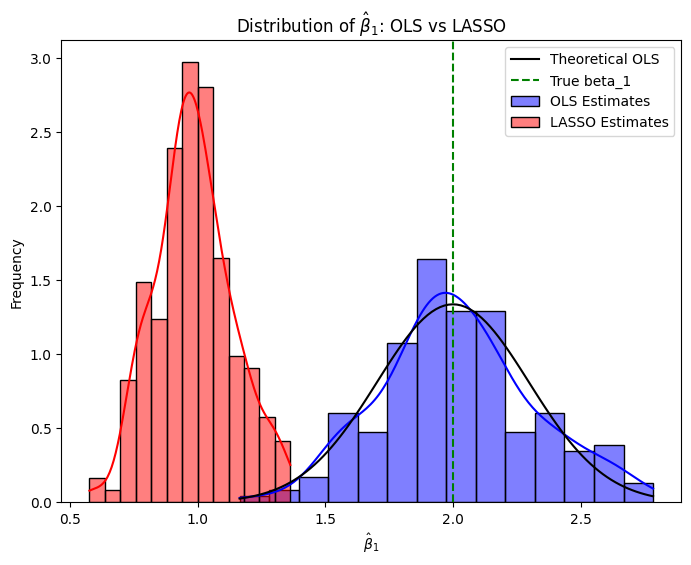

In [78]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Monte Carlo Simulation
n_iterations = 200
n = 50
true_beta_1 = 2
ols_estimates = []
lasso_estimates = []

for _ in range(n_iterations):
    # Generate data
    df = generate_data_simple(n, true_beta_1)

    ols_beta_1 = run_ols(df, 'Y ~ D + W')['beta_1'][0]
    lasso_beta_1 = run_lasso(df, 'Y ~ D + W')['beta_1'][0]

    ols_estimates.append(ols_beta_1)
    lasso_estimates.append(lasso_beta_1)

# Convert to arrays for easier analysis
ols_betas = np.array(ols_estimates)
lasso_betas = np.array(lasso_estimates)

# Plotting distributions or calculating statistics
plt.figure(figsize=(8, 6))
sns.histplot(ols_betas, kde=True, stat='density', label='OLS Estimates', color='blue')
sns.histplot(lasso_betas, kde=True, stat='density', label='LASSO Estimates', color='red')

# Theoretical Normal Curve for OLS
mean_ols = np.mean(ols_betas)
std_ols = np.std(ols_betas)

# Generate x values for plotting the theoretical normal distribution
x = np.linspace(min(ols_estimates), max(ols_estimates), 100)

# Calculate the normalized PDF by dividing by the total area
pdf_values = norm.pdf(x, loc=true_beta_1, scale=std_ols)

# Plot the normalized theoretical distribution
plt.plot(x, pdf_values, label="True Distribution of beta_1", color='black')
plt.axvline(x=true_beta_1, color='green', linestyle='--', label='True beta_1')

# Logistics
plt.legend()
plt.title("Distribution of $\\hat{\\beta}_1$: OLS vs LASSO")
plt.xlabel("$\\hat{\\beta}_1$")
plt.ylabel("Density")


plt.legend()
plt.show()

We see here how OLS demonstrates an unbiased estimate for $\beta_1$, while LASSO is off by quite a bit. We also see that the LASSO estimates are more *precise*, leading to a thinner distribution. These are both expected behaviors; LASSO lowers variance at the expense of shrinking coefficients (therefore inducing bias) in an attempt to minimize overall error, which composes of both variance and bias. This is why, traditionally, LASSO (and other prediction-focused methods) was not seen as a good tool for causal inference, as lowering bias is paramount in inference.

# FWL Theorem

To get started with FWL, first, we define *partialling-out* as a procedure that takes a random variable $V$ and creates a "residualized" error variable $\tilde V$ by subtracting the part of $V$ that is linearly predicted by $W$:

$$\tilde V=V-\gamma'_{VW}W,\text{ }\gamma_{VW}\in\arg\min_\gamma E[(V-\gamma'W)^2]$$

Let's demonstrate what this looks like, graphically.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_data_simple(n=50):
  # define true parameters
  mu, sigma = 0, 1 # mean and standard deviation
  beta_1 = 2
  W = np.random.normal(mu, sigma, size=n)
  e = np.random.normal(0,1,size=n)
  Y = beta_1 * W + e

  # convert to pandas dataframe
  data = pd.DataFrame({
      'Y': Y,
      'W': W,
      'e': e
    })

  return data

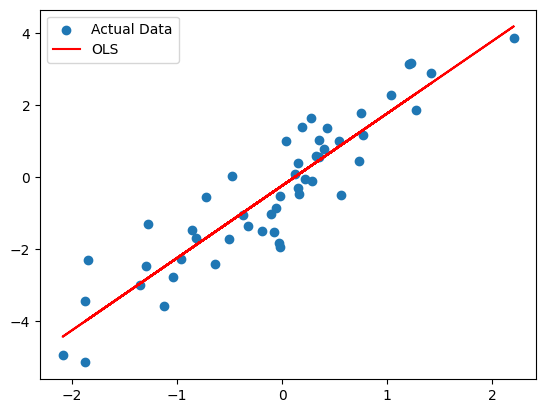

In [31]:
df = generate_data_simple()

# draw the OLS line
import statsmodels.formula.api as smf
model_base = 'Y ~ W'
model = smf.ols(model_base, df).fit()
df['Y_hat'] = model.predict()

plt.scatter(x='W',y='Y',data=df,label='Actual Data') # scatter plot of points
plt.plot('W','Y_hat',data=df,color='red',label='OLS') # plot the OLS
plt.legend()

Now let's plot $\tilde Y$

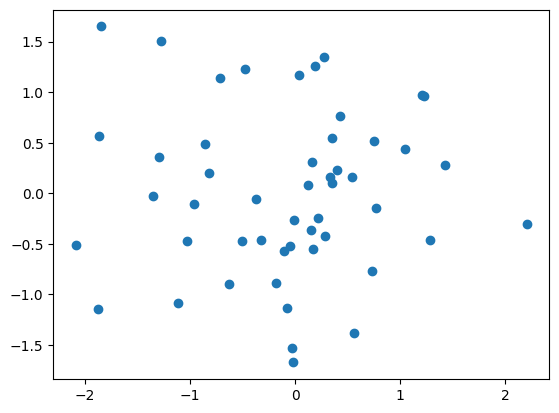

In [32]:
df['Y_tilde'] = df['Y'] - df['Y_hat']

plt.scatter(x='W',y='Y_tilde',data=df,label='Y_tilde') # scatter plot of points

Moving on, we also know that when $V$ is a vector, we apply the operation to each component. It can be shown that the partialling-out operation is linear in the sense that

$$Y=vV+uU\Rightarrow\tilde Y=v\tilde V+u\tilde U$$

We can apply this to our regression equation:

$$Y=\beta_1 D + \beta_2' W + \epsilon\Rightarrow\tilde Y=\beta_1\tilde D+\beta_2'\tilde W+\tilde\epsilon$$

This simplifies our decomposition to be:

$$\tilde Y=\beta_1\tilde D+\epsilon,\text{ }E[\epsilon\tilde D]=0$$

This makes sense because if you partial out the effect of $W$ on $W$, that's just 0. $\epsilon$ is uncorrelated with $W$ so there's nothing to partial out, thus $\tilde\epsilon=\epsilon$

$E[\epsilon\tilde D]=0$ (i.e., $\epsilon\perp\tilde D$) holds because $\epsilon$ is linearly unpredictable by $X$, and $\tilde D$ is a linear function of $X=(D,W')'$.

Now, we move to the full FWL theorem:

**Theorem 1.3.1** (Frisch-Waugh-Lovell, FWL):

The population linear regression coefficient $\beta_1$ can be recovered from the population linear regression of $\tilde Y$ on $\tilde D$:

$$\beta_1=\arg\min_{b_1}E[(\tilde Y-b_1\tilde D)^2]=\frac{E[\tilde D\tilde Y]}{E[\tilde D^2]}$$

where we assume $D$ cannot be perfectly predicted by $W$ ($E[\tilde D^2]> 0$) so that $\beta_1$ is uniquely defined.

Let's demonstrate this. We'll use 2 different cases:
1. Partialling-out via OLS
2. Partialling-out via LASSO

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_data_simple(n=50):
  # define true parameters
  mu, sigma = 0, 1 # mean and standard deviation
  beta_1 = 2
  beta_2 = 3
  beta_3 = 4
  D = np.random.binomial(1,0.5,size=n)
  W_1 = np.random.normal((1/2)*mu + (1/2)*D, sigma, size=n)
  W_2 = np.random.normal(mu, sigma, size=n)
  e = np.random.normal(0,1,size=n)
  Y = beta_1 * D + beta_2 * W_1 + beta_3 * W_2 + e

  # convert to pandas dataframe
  data = pd.DataFrame({
      'Y': Y,
      'D': D,
      'W_1': W_1,
      'W_2': W_2,
      'e': e
    })

  return data

In [36]:
df = generate_data_simple(n=50)
df.head(2)

,Y,D,W_1,W_2,e
0,4.810509,1,1.675327,-1.029248,1.901520
1,7.362777,0,0.606100,1.837224,-1.804418


In [50]:
# Y tilde
model_base = 'Y ~ W_1 + W_2'
model = smf.ols(model_base,df).fit()
df['Y_tilde'] = model.resid

# D tilde
model_base = 'D ~ W_1 + W_2'
model = smf.ols(model_base,df).fit()
df['D_tilde'] = model.resid

Notice below how we arrive at the same estimate for $\beta_1$.

In [51]:
model_base = 'Y_tilde ~ D_tilde'
run_ols(df, model_base, treat='D_tilde')

,p,used_p,R^2,Adj R^2,beta_1
0,2,2,0.534222,0.524518,2.108004


In [52]:
model_base = 'Y ~ D + W_1 + W_2'
run_ols(df, model_base, treat='D')

,p,used_p,R^2,Adj R^2,beta_1
0,4,4,0.963126,0.960722,2.108004


What if we go back to our very flexible model, using OLS?

In [57]:
model_base = 'Y ~ D+W+X+I(W**2)+I(W**3)+I(W**4)+I(X**2)+I(X**3)+I(X**4)'

# Y tilde
model_base = 'Y ~ W_1+W_2+I(W_1**2)+I(W_1**3)+I(W_1**4)+I(W_2**2)+I(W_2**3)+I(W_2**4)'
model = smf.ols(model_base,df).fit()
df['Y_tilde'] = model.resid

# D tilde
model_base = 'D ~ W_1+W_2+I(W_1**2)+I(W_1**3)+I(W_1**4)+I(W_2**2)+I(W_2**3)+I(W_2**4)'
model = smf.ols(model_base,df).fit()
df['D_tilde'] = model.resid

model_base = 'Y_tilde ~ D_tilde'
run_ols(df, model_base, treat='D_tilde')

,p,used_p,R^2,Adj R^2,beta_1
0,2,2,0.528562,0.51874,2.071095


In [59]:
model_base = 'Y ~ D + W_1+W_2+I(W_1**2)+I(W_1**3)+I(W_1**4)+I(W_2**2)+I(W_2**3)+I(W_2**4)'
run_ols(df, model_base, treat='D')

,p,used_p,R^2,Adj R^2,beta_1
0,10,10,0.968099,0.960921,2.071095


Let's actually modify the `run_ols()` to make it appropriate for inference (SE & CI's)

In [71]:
def run_ols_inf(df, model_base, treat='D'):
  """
  example: model_base = 'Y ~ D + W'
  """
  # fit model
  base = smf.ols(model_base, data=df)
  results_base = base.fit()

  # output
  n,p = base.exog.shape
  beta_1 = results_base.params[treat]
  se = results_base.HC3_se[treat]
  ci = np.round(np.array(results_base.conf_int().loc[treat]),4)

  return pd.DataFrame({'p':[p],'used_p':[p],'beta_1': [beta_1],'se':[se],'ci':[ci]})

In [73]:
run_ols_inf(df, model_base, treat='D')

,p,used_p,beta_1,se,ci
0,4,4,2.108004,0.287853,"[1.5238, 2.6922]"


Let's now use LASSO to partition out the effect of the nuisance parameters.

In [74]:
# Y_tilde
model_base = 'Y ~ W_1 + W_2'
base = smf.ols(model_base, df)
X = base.data.exog[:,1:]
y = base.data.endog

# set up LASSO pipeline
lasso = Pipeline([('scale',StandardScaler()),('lasso',lm.LassoCV())])

# fit LASSO
lasso.fit(X,y)

df['Y_tilde'] = df['Y'] - lasso.predict(X)

# D_tilde
model_base = 'D ~ W_1 + W_2'
base = smf.ols(model_base, df)
X = base.data.exog[:,1:]
y = base.data.endog

# set up LASSO pipeline
lasso = Pipeline([('scale',StandardScaler()),('lasso',lm.LassoCV())])

# fit LASSO
lasso.fit(X,y)

df['D_tilde'] = df['D'] - lasso.predict(X)

In [81]:
model_base = 'Y_tilde ~ D_tilde'
run_ols_inf(df, model_base, treat='D_tilde')

,p,used_p,beta_1,se,ci
0,2,2,2.016897,0.290192,"[1.4452, 2.5886]"


In [83]:
model_base = 'Y ~ D + W_1 + W_2'
run_lasso(df, model_base)

,p,used_p,R^2,Adj R^2,beta_1
0,4,3,0.963101,0.959821,1.040062


It looks like using LASSO on the partial out process and then using OLS is able to maintain the correct estimate of $\beta_1$.

In [84]:
# Y_tilde
model_base = 'Y ~ W_1+W_2+I(W_1**2)+I(W_1**3)+I(W_1**4)+I(W_2**2)+I(W_2**3)+I(W_2**4)'
base = smf.ols(model_base, df)
X = base.data.exog[:,1:]
y = base.data.endog

# set up LASSO pipeline
lasso = Pipeline([('scale',StandardScaler()),('lasso',lm.LassoCV())])

# fit LASSO
lasso.fit(X,y)

df['Y_tilde'] = df['Y'] - lasso.predict(X)

# D_tilde
model_base = 'D ~ W_1+W_2+I(W_1**2)+I(W_1**3)+I(W_1**4)+I(W_2**2)+I(W_2**3)+I(W_2**4)'
base = smf.ols(model_base, df)
X = base.data.exog[:,1:]
y = base.data.endog

# set up LASSO pipeline
lasso = Pipeline([('scale',StandardScaler()),('lasso',lm.LassoCV())])

# fit LASSO
lasso.fit(X,y)

df['D_tilde'] = df['D'] - lasso.predict(X)

In [85]:
model_base = 'Y_tilde ~ D_tilde'
run_ols_inf(df, model_base, treat='D_tilde')

,p,used_p,beta_1,se,ci
0,2,2,1.796102,0.285216,"[1.2342, 2.358]"


In [86]:
model_base = 'Y ~ D + W_1 + W_2'
run_lasso(df, model_base)

,p,used_p,R^2,Adj R^2,beta_1
0,4,3,0.963101,0.959821,1.040062


In [87]:
model_base = 'Y ~ D+W+X+I(W**2)+I(W**3)+I(W**4)+I(X**2)+I(X**3)+I(X**4)'

# Y tilde
model_base = 'Y ~ W_1+W_2+I(W_1**2)+I(W_1**3)+I(W_1**4)+I(W_2**2)+I(W_2**3)+I(W_2**4)'
model = smf.ols(model_base,df).fit()
df['Y_tilde'] = model.resid

# D tilde
model_base = 'D ~ W_1+W_2+I(W_1**2)+I(W_1**3)+I(W_1**4)+I(W_2**2)+I(W_2**3)+I(W_2**4)'
model = smf.ols(model_base,df).fit()
df['D_tilde'] = model.resid

model_base = 'Y_tilde ~ D_tilde'
run_ols(df, model_base, treat='D_tilde')

,p,used_p,R^2,Adj R^2,beta_1
0,2,2,0.528562,0.51874,2.071095


In [88]:
model_base = 'Y_tilde ~ D_tilde'
run_ols_inf(df, model_base, treat='D_tilde')

,p,used_p,beta_1,se,ci
0,2,2,2.071095,0.280395,"[1.5034, 2.6387]"


# Behavior of partial-out LASSO on $\hat\beta_1$

As a final step, let's gauge the behavior of the following 3:
1. OLS
2. LASSO
3. Partialled-out LASSO

We'll need to create the partial-out LASSO equivalent of `run_lasso()` and `run_ols()`.

In [92]:
import numpy as np
import pandas as pd

def generate_data_simple(n, beta_1=2):

  # define true parameters
  mu, sigma = 0, 1 # mean and standard deviation
  beta_2 = 1

  # simulate data
  X = np.random.normal(mu, sigma, size=n)
  W = np.random.normal(mu, sigma, size=n)
  D = np.random.binomial(1,0.5,size=n)
  e = np.random.normal(0,1,size=n)
  Y = beta_1 * D + beta_2 * W + e

  # convert to pandas dataframe
  data = pd.DataFrame({
      'Y': Y,
      'D': D,
      'W': W,
      'X': X,
      'e': e
    })

  return data

df = generate_data_simple(n=50)

In [90]:
def run_partial_lasso(df, model_base_y_w, model_base_d_w, model_base_partial):
  # Y tilde
  base = smf.ols(model_base_y_w, df)
  X = base.data.exog[:,1:]
  y = base.data.endog

  # set up LASSO pipeline
  lasso = Pipeline([('scale',StandardScaler()),('lasso',lm.LassoCV())])

  # fit LASSO
  lasso.fit(X,y)

  df['Y_tilde'] = df['Y'] - lasso.predict(X)

  # D tilde
  base = smf.ols(model_base_d_w, df)
  X = base.data.exog[:,1:]
  y = base.data.endog

  # set up LASSO pipeline
  lasso = Pipeline([('scale',StandardScaler()),('lasso',lm.LassoCV())])

  # fit LASSO
  lasso.fit(X,y)

  df['D_tilde'] = df['D'] - lasso.predict(X)

  # partial OLS
  model_base = model_base_partial

  return run_ols(df, model_base, 'D_tilde')

In [93]:
model_base_y_w = 'Y~W'
model_base_d_w = 'D~W'
model_base_partial = 'Y_tilde ~ D_tilde'
run_partial_lasso(df, model_base_y_w, model_base_d_w, model_base_partial)

,p,used_p,R^2,Adj R^2,beta_1
0,2,2,0.473577,0.46261,1.716786


In [94]:
model_base = 'Y~D+W'
run_lasso(df, model_base)

,p,used_p,R^2,Adj R^2,beta_1
0,3,2,0.698845,0.679205,0.84903


In [95]:
model_base = 'Y~D+W'
run_ols(df, model_base)

,p,used_p,R^2,Adj R^2,beta_1
0,3,3,0.698846,0.686031,1.722256


In [99]:
# Monte Carlo Simulation
n_iterations = 200
n = 50
true_beta_1 = 2
ols_estimates = []
lasso_estimates = []
lasso_partial_estimates = []

# model formulas
model_base = 'Y~D+W+X+I(W**2)+I(W**3)+I(W**4)+I(X**2)+I(X**3)+I(X**4)'
model_base_y_w = 'Y~W+X+I(W**2)+I(W**3)+I(W**4)+I(X**2)+I(X**3)+I(X**4)'
model_base_d_w = 'D~W+X+I(W**2)+I(W**3)+I(W**4)+I(X**2)+I(X**3)+I(X**4)'
model_base_partial = 'Y_tilde ~ D_tilde'

for _ in range(n_iterations):
    # Generate data
    df = generate_data_simple(n, true_beta_1)

    # OLS
    ols_beta_1 = run_ols(df, model_base)['beta_1'][0]
    # LASSO
    lasso_beta_1 = run_lasso(df, model_base)['beta_1'][0]
    # Partialled-out LASSO
    lasso_partial_beta_1 = run_partial_lasso(df, model_base_y_w, model_base_d_w, model_base_partial)['beta_1'][0]

    ols_estimates.append(ols_beta_1)
    lasso_estimates.append(lasso_beta_1)
    lasso_partial_estimates.append(lasso_partial_beta_1)

# Convert to arrays for easier analysis
ols_betas = np.array(ols_estimates)
lasso_betas = np.array(lasso_estimates)
lasso_partial_betas = np.array(lasso_partial_estimates)

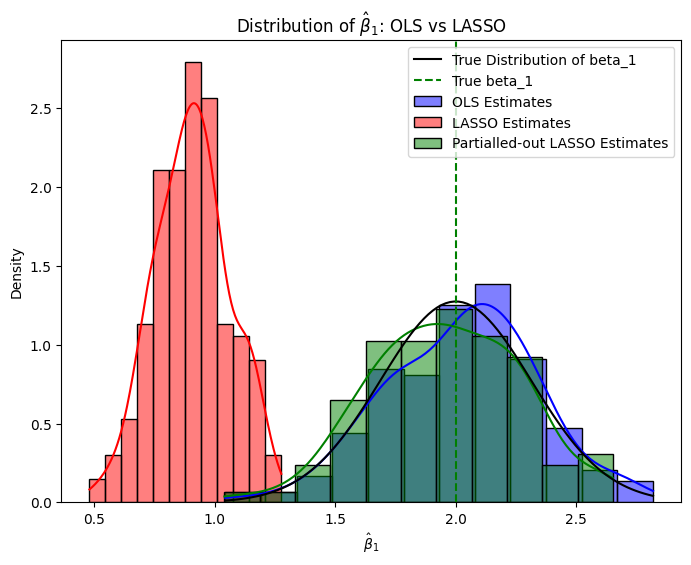

Standard Deviation of OLS Estimates: 0.3130988429489436
Standard Deviation of Partialled-out LASSO Estimates: 0.30995750096935165


In [98]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Plotting distributions or calculating statistics
plt.figure(figsize=(8, 6))
sns.histplot(ols_betas, kde=True, stat='density', label='OLS Estimates', color='blue')
sns.histplot(lasso_betas, kde=True, stat='density', label='LASSO Estimates', color='red')
sns.histplot(lasso_partial_betas, kde=True, stat='density', label='Partialled-out LASSO Estimates', color='green')

# Theoretical Normal Curve for OLS
mean_ols = np.mean(ols_betas)
std_ols = np.std(ols_betas)

# Generate x values for plotting the theoretical normal distribution
x = np.linspace(min(ols_estimates), max(ols_estimates), 100)

# Calculate the normalized PDF by dividing by the total area
pdf_values = norm.pdf(x, loc=true_beta_1, scale=std_ols)

# Plot the normalized theoretical distribution
plt.plot(x, pdf_values, label="True Distribution of beta_1", color='black')
plt.axvline(x=true_beta_1, color='green', linestyle='--', label='True beta_1')

# Logistics
plt.legend()
plt.title("Distribution of $\\hat{\\beta}_1$: OLS vs LASSO")
plt.xlabel("$\\hat{\\beta}_1$")
plt.ylabel("Density")

plt.legend()
plt.show()

# std of OLS vs partialled-out LASSO
print(f"Standard Deviation of OLS Estimates: {np.std(ols_betas)}")
print(f"Standard Deviation of Partialled-out LASSO Estimates: {np.std(lasso_partial_betas)}")

The result here is definitely very relieving. But why do we care? The central thesis to double ML is that we can outsource steps of the causal inference modeling process to Machine Learning, which is very good at handling complex relationships, high-dimensional data, and non-traditional parameters. In essense, it has found a way to leech off of the ML literature to empower inference. Remember that traditionally, this was difficult. As we saw above, if we try to use LASSO regression without care, then we end up with biased estimates of $\beta_1$, even if we improve or maintain the predictive capability.

A final note before this notebook concludes - readers may wonder, how does the uncertainty that comes from estimating $\tilde Y,\tilde D$ have on the asymptotic behavior of partialled-out $\hat\beta_1$? The text reassures (through the book's Theorem 1.3.2: Adaptive Inference) that the estimation of the residuals has an inconsequential impact on the large sample properties of the concluding OLS estimator. This adaptivity property is derived later as a consequence of a more general phenomenom called *Neyman Orthogonality*.